In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"Blaq's PDF Chatbot - {unique_id}"

----------------------------------------


In [2]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [3]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={'k': 2, 'score_threshold': 0.5}
    )    # (search_type="mmr", search_kwargs={"fetch_k": 5})  # I am using mmr for diversity in retrieved docs to reduce 
else:                                                                                                   # context redundancy
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={'k': 2, 'score_threshold': 0.5}
    )
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser


prompt = PromptTemplate(
    template="""You are an expert at routing user questions to the appropriate data source. Based on the provided question, please classify it into one of the following categories:

1. vectorstore: Questions related to human nutrition (including food quality, units of measure, healthy diet, scientific research in nutrition, the human body's systems, water and electrolytes, carbohydrates, lipids, proteins, alcohol, energy, vitamins, minerals, lifespan nutrition, performance nutrition, food safety, nutritional issues, and careers in nutrition).
2. web_search: Questions that require up-to-date information and could be found on the internet.
3. off_topic: Questions that are personal enquiries, inappropriate comments, or irrelevant/flirty innuendos.

Examples:
    What is the capital of France? -> "DATASOURCE":"web_search"
    What are macronutrients? -> "DATASOURCE":"vectorstore"
    What are the latest nutrition trends? -> "DATASOURCE":"web_search"
    How does the body ensure adequate energy during prolonged physical activity? -> "DATASOURCE":"vectorstore"
    Who owns the restaurant? -> "DATASOURCE":"offtopic"
    I like you, do you like me? -> "DATASOURCE":"offtopic"
    What are macronutrients? -> "DATASOURCE":"vectorstore"
    Which club did Messi last score against? -> "DATASOURCE":"web_search"
    When was McGregor's last fight? -> "DATASOURCE":"web_search"
    Is Brazil competiting at the 2024 Olympics? -> "DATASOURCE":"web_search"
    Will you marry me? -> "DATASOURCE":"offtopic"
If the question falls into one of these categories, respond with a JSON object containing a single key 'DATASOURCE'. Only reply with each classification such as 'vectorstore', 'classified', or 'web_search'. Please no preamble or explanation.

Question: {question}

JSON Response:
 """,
    input_variables=["question"],
)
# LLM
llm = ChatOllama(model="gemma:2b", format="json", temperature=0)
question_router = prompt | llm | JsonOutputParser()

To try it out:

In [5]:
question = "What day of the week is today?"
response = question_router.invoke({"question": question})

# Extract the value of 'DATASOURCE'
value = response.get("DATASOURCE", "No key found")
print(f"QUESTION and GRADE: {question} - {value}")

QUESTION and GRADE: What day of the week is today? - web_search


### Retrieval Grader 


In [6]:
### Retrieval Grader 

from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import JsonOutputParser



grader_prompt = PromptTemplate(
    template="""You are a grader assessing the relevance of a retrieved document to a user question.

Here is the retrieved document:

{document}

Here is the user question:

{question}

To assess the relevance of the document to the question, please use semantic similarity to compare the meaning of the document and the question. If the document contains information that is semantically similar to the user question, grade it as relevant. Do not be stringent with the keywords. The goal is to filter out erroneous retrievals.

Give a binary score 'yes' to indicate that the document is relevant to the question, or 'no' to indicate that the document is NOT relelvant to the question .

Provide the binary score as a JSON object with a single key 'score' and no preamble or explanation.

JSON Response:""",
    input_variables=["question", "document"],
)

# LLM
#llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
llm = ChatGroq(temperature=0.1, model_name="gemma2-9b-it")
retrieval_grader = grader_prompt | llm | JsonOutputParser()


In [7]:
question = "How do proteins contribute to the structure and texture of foods?"
docs = retriever.get_relevant_documents(question)
scores = []

for i, doc in enumerate(docs):
    response = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    scores.append(response)
    print(f"Document {i+1}: {response['score']}")




c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Document 1: yes
Document 2: yes


In [8]:
scores

[{'score': 'yes'}, {'score': 'yes'}]

If you've adjusted the retriever's parameters and are working with more than a couple documents, it's advisable to uncomment and run the code blocks below. This will help prevent overwhelming your generator LLM with too many context documents, which could exceed the LLM's token length limitations.

**Compressor**

In [20]:
#from langchain.retrievers import ContextualCompressionRetriever
#from langchain.retrievers.document_compressors import CrossEncoderReranker
#from langchain_community.cross_encoders import HuggingFaceCrossEncoder

#model = HuggingFaceCrossEncoder(model_name="sentence-transformers/all-MiniLM-L6-v2")  #BAAI/bge-large-en-v1.5 
#compressor = CrossEncoderReranker(model=model, top_n=2)
#compression_retriever = ContextualCompressionRetriever(
    #base_compressor=compressor, base_retriever=retriever
#)

In [21]:
#question = "How do proteins contribute to the structure and texture of foods?"
#docs = compression_retriever.get_relevant_documents(question)
#docs



In [22]:
#for i, doc in enumerate(docs):
    #response = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    #scores.append(response)
    #print(f"Document {i+1}: {response['score']}")

In [9]:
### Question Re-writer
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser


# Prompt 
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized 
     for vectorstore semantic retrieval. Look at the initial and formulate an improved question. 
     Here is the initial question:  {question}. 
     Revised question:  
     Please no preamble or extra sentences just the revised question will suffice.""",
    input_variables=["question"],
)

# LLM
llm = ChatGroq(temperature=0.1, model_name="gemma2-9b-it")
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [10]:
question = "What are macronutrients?"
response = question_rewriter.invoke({"question": question})

print(f"ORIGINAL QUESTION: {question}")
print(f"IMPROVED QUESTION: {response}")

ORIGINAL QUESTION: What are macronutrients?
IMPROVED QUESTION: Define macronutrients.  



In [25]:
#question = response
#docs = compression_retriever.invoke(question)
#for i, doc in enumerate(docs):
    #response = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    #scores.append(response)
    #print(f"Document {i+1}: {response['score']}")

In [11]:
### Generate

from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Prompt
prompt = PromptTemplate(
    template="""Answer the following question based only on the provided context. 
Question: {question}
Context: {documents}""",
    input_variables=["question", "documents"],
)


# Chain
rag_chain = prompt | llm | StrOutputParser()
# LLM
#llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
llm = ChatGroq(temperature=0.1, model_name="gemma2-9b-it")

In [12]:
question = question
docs = retriever.invoke(question)
docs = format_docs(docs)
response = rag_chain.invoke({"question": question, "documents": docs})
print(response)

Macronutrients are nutrients that are needed in large amounts.  



In [13]:
docs

'Macronutrients \nNutrients \nthat \nare \nneeded \nin \nlarge \namounts \nare \ncalled \nmacronutrients. There are three classes of macronutrients: \ncarbohydrates, lipids, and proteins. These can be metabolically \nprocessed into cellular energy. The energy from macronutrients \ncomes from their chemical bonds. This chemical energy is \nconverted into cellular energy that is then utilized to perform work, \nallowing our bodies to conduct their basic functions. A unit of'

In [14]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Provide your Tavily Search Api Key here: ")
  print("TAVILY_API_KEY successfully sent to the environment")

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

In [16]:
query = "Who is the bantam weight UFC champion of the world?"

In [35]:
web_search_tool.invoke(query)

[{'url': 'https://www.sportskeeda.com/mma/ufc-bantamweight',
  'content': 'At UFC 173, T.J. Dillashaw defeated Renan Barao to win the UFC Bantamweight Championship. At UFC Fight Night: Dillashaw vs Cruz, Dominick Cruz became the first-ever two-time Bantamweight Champion.'},
 {'url': 'https://www.ufc.com/news/ufc-bantamweight-title-lineage-cruz-dillashaw-garbrandt-cejudo-yan-sterling',
  'content': 'Dominick Cruz (2010-2014) WEC bantamweight champion who defeated Scott Jorgensen at WEC 53 on December 16, 2010 to win first UFC Bantamweight Championship.Defended title successfully against ...'},
 {'url': 'https://406mtsports.com/professional/helena-native-sean-omalley-wins-ufc-bantamweight-world-title/article_45bb1630-3f07-11ee-8eac-4b91442858bc.html',
  'content': "BOSTON — Sean O'Malley's career has been like a fairytale and the latest chapter was written Saturday night in Boston. Fighting as part of the co-Main Event at UFC 292, O'Malley (17-1), a Helena native, completed his prophecy 

**NB**: 

Occasionally, the web_search_tool may encounter ConnectionError issues. If this happens, simply rerun the cell, and it should work fine.

In [17]:
from typing_extensions import TypedDict


class AgentState(TypedDict):
    question: str
    scores: list[str]
    llm_output: str
    documents: list[str]
    ON_TOPIC: bool

In [18]:
### Edges ###

#from langchain.schema import Document

def route_question(state: AgentState):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    question = state["question"]
    print(f"Query: {question}")
    print("Knowledge base OR the internet?...")
    route = question_router.invoke({"question": question})  
    value = route.get("DATASOURCE", "No key found")
    
    if value.lower() == 'web_search':
        print("I need to search the internet...")
        return "web_search"
    elif value.lower() == 'vectorstore':
         print("I need to search the knowledge base...") 
         return "vectorstore"
    message = "OFF_TOPIC"
    return message
    

def decide_to_generate(state: AgentState):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("Are these documents good?...")

    scores = state["scores"]

    if any(score.lower() == "no" for score in scores):
        #filtered_grades = [score for score in scores if score.lower() == "no"]
        return "rewrite_query"
    else:
        return "generate"

In [19]:
### Nodes ###
def retrieve_docs(state: AgentState):
    print("Retrieving documents...")
    
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)  #compression_
    
    for n, doc in enumerate(documents, start=1):
        print(f"RETRIEVED DOCUMENT {n}")
    state["documents"] = [doc.page_content for doc in documents]

    return state

def grade_documents(state: AgentState):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (AgentState): The current graph state

    Returns:
        AgentState: Updates documents key with only filtered relevant documents
    """
    print("Grading retrieved documents...")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    scores = []
    for i, doc in enumerate(documents):
        response = retrieval_grader.invoke({"question": question, "document": doc})
        score = response.get("score", "No key found")
        scores.append(score)
        
        print(f"Is Document {i+1} RELEVANT?: {score}")
        if score == "yes":
            filtered_docs.append(doc)
    state["documents"] = filtered_docs
    state["scores"] = scores
    return state

#def format_docs(docs):
    #return "\n\n".join(doc for doc in docs)
def format_docs(docs):
    # Ensure that the documents are strings before joining
    return "\n\n".join(doc if isinstance(doc, str) else doc.page_content for doc in docs)
    


def generate(state: AgentState):
    """
    Generate answer

    Args:
        state (AgentState): The current graph state

    Returns:
        AgentState: New key added to state, llm_output, that contains LLM generation
    """
    print("Generating response...")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"documents": format_docs(documents), "question": question})
    
    state["llm_output"] = generation
    return state

def transform_query(state: AgentState):
    """
    Transform the query to produce a better question.

    Args:
        state (AgentState): The current graph state

    Returns:
        AgentState: Updates question key with a re-phrased question
    """
    print("Re-writing user query...")
    question = state["question"]

    better_question = question_rewriter.invoke({"question": question})
    state["question"] = better_question
    return state

def off_topic_response(state: AgentState):
    """
    Generate answer using the substitute LLM
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation2, that contains substitute llm responses
    """
   
    message = "I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents."
    print(message)
    state["llm_output"] = message
    return state

def web_search(state: AgentState):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results as strings
    """
    print("Searching the internet...")
    question = state["question"]

    # Perform web search and retrieve results
    docs = web_search_tool.invoke(question)
    

    # Process the search results by extracting the content
    web_results = "\n".join(d.get("content", "") if isinstance(d, dict) else d for d in docs)
    
    # Convert the concatenated web results into a string
    web_results_str = web_results

    # Append the web search results to the existing documents in the state
    if "documents" in state:
        state["documents"].append(web_results_str)
        state["question"] = question
    else:
        state["documents"] = [web_results_str]
        state["question"] = question
   
    return state

In [20]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)


workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)
workflow.add_node("web_search", web_search)
workflow.add_node("grade_documents", grade_documents)

# Set the entry point
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve_docs",
        "OFF_TOPIC": "off_topic_response"
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve_docs", "grade_documents")
workflow.add_edge("off_topic_response", END)


workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "rewrite_query": "transform_query",
    },
)
workflow.add_edge("transform_query", "retrieve_docs")
workflow.add_edge("generate", END)




app = workflow.compile()  #debug=True

In [113]:
#from IPython.display import Image, display

##try:
   # display(Image(app.get_graph(xray=True).draw_mermaid_png()))
#except:
##    pass

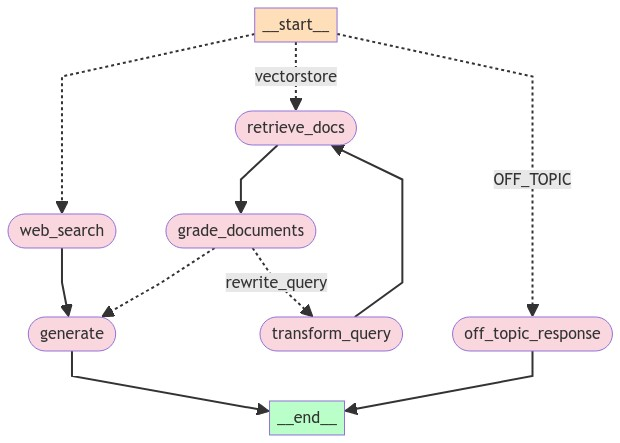

In [40]:
from IPython.display import Image, display

app.get_graph().draw_mermaid_png(output_file_path="graph.png")

# Display the image
display(Image(filename="graph.png"))

In [21]:
result = app.invoke({"question": "what are macronutrients?"})   #, config = {"configurable": {"thread_id": "2"}
result["llm_output"]

Query: what are macronutrients?
Knowledge base OR the internet?...
I need to search the knowledge base...
Retrieving documents...
RETRIEVED DOCUMENT 1
Grading retrieved documents...
Is Document 1 RELEVANT?: yes
Are these documents good?...
Generating response...


'Macronutrients are nutrients that are needed in large amounts.  \n'

In [22]:
from pprint import pprint

# Run 
inputs = {"question": "How do proteins contribute to the structure and texture of foods?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["llm_output"])

Query: How do proteins contribute to the structure and texture of foods?
Knowledge base OR the internet?...
I need to search the knowledge base...
Retrieving documents...
RETRIEVED DOCUMENT 1
RETRIEVED DOCUMENT 2
"Node 'retrieve_docs':"
'\n---\n'
Grading retrieved documents...
Is Document 1 RELEVANT?: yes
Is Document 2 RELEVANT?: yes
Are these documents good?...
"Node 'grade_documents':"
'\n---\n'
Generating response...
"Node 'generate':"
'\n---\n'
('Proteins provide food with structure and texture. They can foam when '
 'agitated, creating airy textures like in angel food cake.  They can also '
 'coagulate, increasing thickness as seen in yogurt. \n')


In [23]:
result = app.invoke({"question": "Who is the bantam weight UFC champion of the world?", "documents":[]})
result["llm_output"]

Query: Who is the bantam weight UFC champion of the world?
Knowledge base OR the internet?...
I need to search the internet...
Searching the internet...
Generating response...


"Sean O'Malley is the current UFC Bantamweight Champion of the world. \n"